In [ ]:
from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from ipywidgets import (
    FloatText,
    IntText,
    BoundedIntText,
    Dropdown,
    HBox,
    VBox,
    Button,
    Output,
    Layout,
)

DATA_PATH = Path("qpsk_high_snr_sps_4_float32.pcm")  


def read_iq_int16(path: Path, normalize: bool = True) -> np.ndarray:
    """Читает int16 IQ-файл и возвращает комплексный массив."""
    raw = np.fromfile(path, dtype=np.float32)
    if raw.size < 2:
        raise ValueError("Файл должен содержать хотя бы одну пару I/Q отсчётов.")
    if raw.size % 2:
        raw = raw[:-1]
    i = raw[0::2].astype(np.float32)
    q = raw[1::2].astype(np.float32)
    iq = i + 1j * q
    if normalize:
        peak = np.max(np.abs(iq))
        if peak > 0:
            iq = iq / peak
    return iq.astype(np.complex64)



In [ ]:
try:
    iq_samples = read_iq_int16(DATA_PATH)
    print(f"Загружено {iq_samples.size} комплексных отсчётов из {DATA_PATH.name}")
    print(f"Пример первых 5 отсчётов: {iq_samples[:5]}")
except FileNotFoundError:
    iq_samples = np.array([], dtype=np.complex64)
    print(f"Файл {DATA_PATH} не найден. Укажите корректный путь в переменной DATA_PATH.")
except Exception as exc:
    iq_samples = np.array([], dtype=np.complex64)
    print(f"Ошибка при чтении: {exc}")



Загружено 41999 комплексных отсчётов из qpsk_high_snr_sps_4_float32.pcm
Пример первых 5 отсчётов: [ 0.2706812 +0.29097143j  0.25444534+0.44324088j  0.13974805+0.4805394j
 -0.09799641+0.35583457j -0.3843561 +0.11444479j]


In [ ]:
def apply_integer_delay(signal: np.ndarray, delay: int) -> np.ndarray:
    if signal.size == 0 or delay == 0:
        return signal
    if delay > 0:
        if delay >= signal.size:
            return np.array([], dtype=signal.dtype)
        return signal[delay:]
    shift = abs(delay)
    padded = np.pad(signal, (shift, 0), mode="constant")
    return padded[: signal.size]


def apply_fractional_delay_lagrange(signal: np.ndarray, frac_delay: float) -> np.ndarray:
    if signal.size == 0 or abs(frac_delay) < 1e-9:
        return signal
    n = np.arange(signal.size, dtype=np.float32)
    interpolator = interp1d(
        n,
        signal,
        kind="cubic",
        bounds_error=False,
        fill_value="extrapolate",
        assume_sorted=True,
    )
    shifted = interpolator(n - frac_delay)
    return shifted.astype(signal.dtype)


def compensate_delay_lagrange(signal: np.ndarray, delay_samples: float) -> np.ndarray:
    if signal.size == 0 or abs(delay_samples) < 1e-9:
        return signal
    int_delay = int(np.floor(delay_samples))
    frac_delay = float(delay_samples - int_delay)
    delayed = apply_integer_delay(signal, int_delay)
    if abs(frac_delay) > 1e-9:
        delayed = apply_fractional_delay_lagrange(delayed, frac_delay)
    return delayed



In [ ]:
def slice_symbols(signal: np.ndarray, sps: int, offset: int = 0, max_points: int | None = None) -> np.ndarray:
    """Выбирает по одному отсчёту на символ из передискретизированного сигнала."""
    if signal.size == 0 or sps <= 0:
        return np.array([], dtype=np.complex64)
    start = max(offset, 0)
    symbols = signal[start::sps]
    if max_points is not None:
        symbols = symbols[:max_points]
    return symbols



In [ ]:

f_rel = 0.0164315803

if iq_samples.size and not np.isclose(f_rel, 0.0):
    n = np.arange(iq_samples.size, dtype=np.float32)
    iq_baseband = iq_samples * np.exp(-1j * 2 * np.pi * f_rel * n)
    print("Компенсация по оценённому f_rel выполнена.")
else:
    iq_baseband = iq_samples.copy()
    print("Компенсация не выполнялась (f_rel≈0 или нет данных).")



Компенсация по оценённому f_rel выполнена.


In [ ]:
X0 = 0  # задержка в отсчётах (положительная -> сдвигаем сигнал вперёд во времени)

if iq_baseband.size:
    iq_time_aligned = compensate_delay_lagrange(iq_baseband, X0)
    print(f"Компенсация задержки на {X0:+.3f} отсчётов выполнена.")
    print(f"Пример первых 5 отсчётов после выравнивания: {iq_time_aligned[:5]}")
else:
    iq_time_aligned = iq_baseband.copy()
    print("Нет данных для компенсации задержки.")



Компенсация задержки на +0.000 отсчётов выполнена.
Пример первых 5 отсчётов после выравнивания: [ 0.2706812 +0.29097143j  0.2987706 +0.41465774j  0.23530021+0.44168028j
  0.01512483+0.368772j   -0.30611396+0.25907815j]


In [ ]:
SPS = 1  # количество отсчётов на символ, задаётся пользователем
SYMBOL_OFFSET = 0  # смещение выборки внутри символа (0 ... SPS-1)

symbols = slice_symbols(iq_time_aligned, SPS, offset=SYMBOL_OFFSET, max_points=MAX_POINTS)
print(f"Выбрано символов для созвездия: {symbols.size}")



Выбрано символов для созвездия: 10000


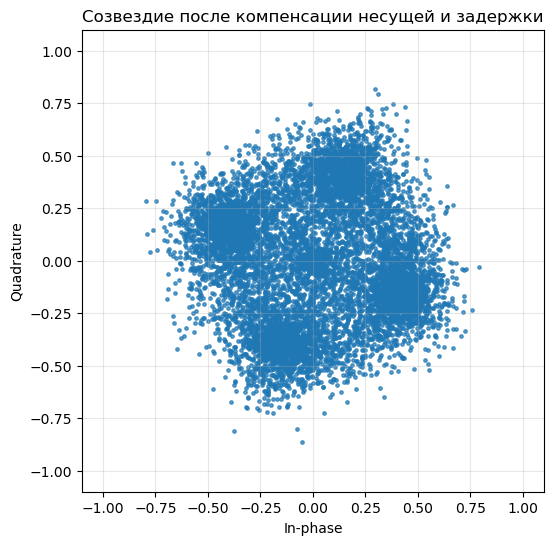

In [ ]:
MAX_POINTS = 10000

source_signal = (
    symbols if 'symbols' in locals() and symbols.size else (
        iq_time_aligned if 'iq_time_aligned' in locals() and iq_time_aligned.size else iq_baseband
    )
)
points = source_signal[:MAX_POINTS] if source_signal.size else np.array([], dtype=np.complex64)

if points.size:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(points.real, points.imag, s=6, alpha=0.7)
    title = "Созвездие после компенсации несущей и задержки" if 'iq_time_aligned' in locals() else "Созвездие после компенсации несущей"
    ax.set_title(title)
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect("equal", "box")
    plt.show()
else:
    print("Нет данных для отображения. Запустите предыдущие ячейки.")



In [ ]:
def update_constellation_view(f_rel: float, delay: float, sps: int, offset: int) -> None:
    if iq_samples.size == 0:
        print("Нет загруженных IQ-данных. Выполните ячейку чтения файла.")
        return

    n = np.arange(iq_samples.size, dtype=np.float32)
    baseband = iq_samples * np.exp(-1j * 2 * np.pi * f_rel * n)
    aligned = compensate_delay_lagrange(baseband, delay)

    sps = max(int(sps), 1)
    offset = int(np.clip(offset, 0, max(sps - 1, 0)))
    symbols_local = slice_symbols(aligned, sps, offset=offset, max_points=MAX_POINTS)
    points = symbols_local if symbols_local.size else aligned[:MAX_POINTS]

    if points.size == 0:
        print("Недостаточно данных для построения созвездия.")
        return

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(points.real, points.imag, s=6, alpha=0.7)
    ax.set_title("Интерактивное созвездие")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect("equal", "box")
    plt.show()

    print(f"f_rel = {f_rel:+.6f}, delay = {delay:+.3f} отсчёта")
    print(f"sps = {sps}, offset = {offset}, отображаемых точек: {points.size}")



In [ ]:
f_rel_widget = FloatText(
    value=float(f_rel_est) if 'f_rel_est' in locals() else 0.0,
    description="f_rel",
    step=1e-7,
    layout=Layout(width="200px"),
)
delay_widget = FloatText(
    value=float(X0) if 'X0' in locals() else 0.0,
    description="Delay",
    step=0.01,
    layout=Layout(width="160px"),
)
sps_widget = BoundedIntText(
    value=int(SPS) if 'SPS' in locals() else 4,
    min=1,
    max=64,
    description="SPS",
    layout=Layout(width="160px"),
)
offset_widget = BoundedIntText(
    value=int(SYMBOL_OFFSET) if 'SYMBOL_OFFSET' in locals() else 0,
    min=0,
    max=max((int(SPS) if 'SPS' in locals() else 4) - 1, 0),
    description="Offset",
    layout=Layout(width="160px"),
)
refresh_button = Button(description="Обновить", button_style="primary")
plot_output = Output()


def adjust_offset_range(change=None):
    offset_widget.max = max(sps_widget.value - 1, 0)
    if offset_widget.value > offset_widget.max:
        offset_widget.value = offset_widget.max

def trigger_update(change=None):
    adjust_offset_range()
    if change is not None and getattr(change, "name", None) == "value" and change.old == change.new:
        return
    with plot_output:
        plot_output.clear_output(wait=True)
        update_constellation_view(
            f_rel_widget.value,
            delay_widget.value,
            sps_widget.value,
            offset_widget.value,
        )


for widget in (f_rel_widget, delay_widget, sps_widget, offset_widget):
    widget.observe(trigger_update, names="value")

refresh_button.on_click(trigger_update)

controls = VBox([
    HBox([f_rel_widget, delay_widget, sps_widget, offset_widget, refresh_button]),
])

display(VBox([controls, plot_output]))
trigger_update()

